# Ensembling & Optimization
### Goal: Maximize performance
## Methods
 - Weighted averaging
 - Stacking (ML + DL)
 - Bias correction
 - Post-processing (zero-sales handling)
### 📌 Output: Final optimized model

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 329 (delta 60), reused 37 (delta 8), pack-reused 216 (from 1)
Receiving objects: 100% (329/329), 41.98 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Updating files: 100% (58/58), done.
Filtering content: 100% (22/22), 348.58 MiB | 44.03 MiB/s, done.


In [2]:
!pip install -q catboost
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.5 MB/s eta 0:00:00


In [3]:

# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

import os
from pathlib import Path
import gc

In [4]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [5]:
import joblib
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

# Random Forest
rf_model = joblib.load("models/random_forest/random_forest.pkl")

# Target Encoder
tt = joblib.load("models/random_forest/target_encoder.pkl")

# CatBoost
cat_model = CatBoostRegressor()
cat_model.load_model("models/catboost/catboost.cbm")

# LightGBM
lgb_model = lgb.Booster(model_file="models/lightgbm/baseline_lightgbm.txt")

# XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgboost/xgboost.json")

In [6]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [7]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()


0

In [8]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)


In [9]:
# Drop NaN values in Lag/Roll Features
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]
train = train.dropna(subset=lag_cols).reset_index(drop=True)

In [10]:
# Define Target and Features
TARGET = 'sales_log'
y_true = train[TARGET]

In [11]:
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X_true = train[FEATURES]

In [12]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()

# Handling Categorical Features
X_true_te = tt.transform(X_true)


# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

# MAE Evaluation Function
def mae(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    y_pred = np.maximum(y_pred, 0)
    return mean_absolute_error(y_true, y_pred)


## Validation Prediction

In [13]:
# RF Validation Prediction
rf_valid_pred = rf_model.predict(X_true_te)

# XGB Validation prediction
xgb_valid_pred = xgb_model.predict(xgb.DMatrix(X_true_te))

# LightGBM Validation Prediction
lgb_valid_pred = lgb_model.predict(
    X_true,
    num_iteration=lgb_model.best_iteration
)

# CatBoost Validation Prediction
cat_valid_pred = cat_model.predict(X_true)

##  Evaluation Metrics

In [14]:
metrics = {

    "RandomForest": {
        "RMSLE": rmsle(y_true, rf_valid_pred),
        "MAE": mae(y_true, rf_valid_pred),
    },
    "XGBoost": {
        "RMSLE": rmsle(y_true, xgb_valid_pred),
        "MAE": mae(y_true, xgb_valid_pred),
    },
    "LightGBM": {
        "RMSLE": rmsle(y_true, lgb_valid_pred),
        "MAE": mae(y_true, lgb_valid_pred),
    },
    "CatBoost": {
        "RMSLE": rmsle(y_true, cat_valid_pred),
        "MAE": mae(y_true, cat_valid_pred),
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSLE,MAE
RandomForest,0.420985,59.492132
XGBoost,0.358644,41.652336
LightGBM,0.346664,40.643089
CatBoost,0.393336,52.850364


## WEIGHTED AVERAGING
<pre>
Combine 4 models: RandomForest, XGBoost, LightGBM, CatBoost into one stronger predictor by learning optimal weights.
</pre>

In [21]:
# Prepare Prediciton matrix
ensemble_df = pd.DataFrame({
    "y_true": y_true,
    "RandomForest": rf_valid_pred,
    "XGBoost": xgb_valid_pred,
    "LightGBM": lgb_valid_pred,
    "CatBoost": cat_valid_pred
})

In [22]:
# Simple Baseline : Equal Weight
ensemble_df['avg_pred'] = (
    ensemble_df['RandomForest'] +
    ensemble_df['XGBoost'] +
    ensemble_df['LightGBM'] +
    ensemble_df['CatBoost']
) / 4


In [23]:
# Evaluate
baseline_rmsle = rmsle(
    ensemble_df['y_true'].values,
    ensemble_df['avg_pred'].values
)
baseline_mae = mae(
    ensemble_df['y_true'].values,
    ensemble_df['avg_pred'].values
)
baseline_rmsle, baseline_mae

(np.float64(0.36859132750955187), 45.615535908194616)

## Optimize Weights
<pre>
Equal weights assume all models are equally good — false in practice.

Method:
  final_pred = w1*RF + w2*XGB + w3*LGB + w4*CAT

Subject to:
  w_i ≥ 0
  w1 + w2 + w3 + w4 = 1

🎯 Objective: Minimize RMSLE

In [24]:
# Define Optimization Objective
from scipy.optimize import minimize

def weighted_rmsle(weights, df):
  pred = (
      weights[0] * df['RandomForest'].values +
      weights[1] * df['XGBoost'].values +
      weights[2] * df['LightGBM'].values +
      weights[3] * df['CatBoost'].values
  )
  return rmsle(df['y_true'].values, pred)

In [26]:
from scipy.sparse import construct
# Initial equal weight
initial_weights = [0.25] * 4

# Constraints
constraints = ({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
})

# Each Weight between 0 and 1
bounds = [(0, 1)] * 4

In [27]:
# Run Optimization
opt_result = minimize(
    weighted_rmsle,
    initial_weights,
    args=(ensemble_df),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weight = opt_result['x']
opt_weight

array([2.18079593e-17, 0.00000000e+00, 1.00000000e+00, 1.11022302e-16])

In [28]:
# Final Weight Ensemble prediction
ensemble_df['opt_pred'] = (
    opt_weight[0] * ensemble_df['RandomForest'] +
    opt_weight[1] * ensemble_df['XGBoost'] +
    opt_weight[2] * ensemble_df['LightGBM'] +
    opt_weight[3] * ensemble_df['CatBoost']
)

In [29]:
# Evaluate Optimized Ensemble
final_rmsle = rmsle(
    ensemble_df['y_true'].values,
    ensemble_df['opt_pred'].values
)

final_mae = mae(
    ensemble_df['y_true'].values,
    ensemble_df['opt_pred'].values
)

final_rmsle, final_mae

(np.float64(0.3466643303966908), 40.64308918042002)

In [30]:
# Save Optimized Model
import json

weights_dict = {
    "rf": float(opt_weight[0]),
    "xgb": float(opt_weight[1]),
    "lgb": float(opt_weight[2]),
    "cat": float(opt_weight[3]),
}

with open("models/ensemble_weights.json", "w") as f:
    json.dump(weights_dict, f, indent=4)

## STACKING ENSEMBLE
 - Use predictions from RF, XGB, LGB, CatBoost as features
 - Train a meta-model to learn when to trust which model.
<pre>
Base Models → Predictions → Meta-Model → Final Prediction
</pre>


In [31]:
# Prepare Meta-Model Dataset
stack_df = pd.DataFrame({
    "rf": rf_valid_pred,
    "xgb": xgb_valid_pred,
    "lgb": lgb_valid_pred,
    "cat": cat_valid_pred,
    "y_true": y_true
})

In [32]:
# Features and Target
X_stack = stack_df.drop(columns=['y_true'])
y_stack = stack_df['y_true']

In [33]:
# Baseline Meta-Model: Ridge Regression
from sklearn.linear_model import Ridge

meta_model = Ridge(alpha=0.1)
meta_model.fit(X_stack, y_stack)

Ridge(alpha=0.1)

In [34]:
# Meta-Model Prediction
stack_pred = meta_model.predict(X_stack)

In [35]:
# Evaluate Stacking Performance
stack_rmsle = rmsle(y_stack, stack_pred)
stack_mae = mae(y_stack, stack_pred)

stack_rmsle, stack_mae

(np.float64(0.34350839833529406), 40.40088079558548)

In [38]:
# Intrepret Meta-Model Weights
pd.Series(
    meta_model.coef_,
    index=X_stack.columns
).sort_values(ascending=False)

,0
lgb,1.097588
xgb,0.253538
rf,0.015563
cat,-0.366768


In [ ]:
# Stronger Meta-Model: LightGBM Model
meta_lgb = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    random_state=42,
    max_depth=3
)

meta_lgb.fit(X_stack, y_stack)

In [40]:
# Prediction and Evaluation
stack_lgb_pred = meta_lgb.predict(X_stack)

stack_lgb_rmsle = rmsle(y_stack, stack_lgb_pred)
stack_lgb_mae = mae(y_stack, stack_lgb_pred)

stack_lgb_rmsle, stack_lgb_mae

(np.float64(0.3430243662232667), 45.298439686788356)

In [42]:
# Save meta Model
joblib.dump(meta_model, "models/meta_model.pkl")
joblib.dump(meta_lgb, "models/meta_lgb.pkl")

['models/meta_lgb.pkl']

## BIAS CORRECTION (POST-ENSEMBLE)
<pre> Fix systematic under- or over-prediction after ensembling.</pre>
### Most demand models:
 - Under-predict peaks
 - Slightly shrink variance
 - Are biased after log1p → expm1
### Bias correction fixes this.

In [43]:
# Apply Bias Correlation
y_true_log = y_stack
y_pred_log = stack_pred

In [45]:
# Compute Bias
bias = np.mean(y_true_log - y_pred_log)

# Apply Bias
y_pred_bias_corrected = y_pred_log + bias

bias

np.float64(1.2698449385745826e-16)

In [47]:
# Evaluate Before vs After
rmsle_before = rmsle(y_true_log, y_pred_log)
rmsle_after = rmsle(y_true_log, y_pred_bias_corrected)

mae_before = mae(y_true_log, y_pred_log)
mae_after = mae(y_true_log, y_pred_bias_corrected)

rmsle_before, rmsle_after, mae_before, mae_after

(np.float64(0.34350839833529406),
 np.float64(0.34350839833529406),
 40.40088079558548,
 40.40088079558548)

## ZERO-SALES HANDLING (POST-PROCESSING)
 - Reduce RMSLE penalty caused by:
 - Very small predictions for true zero sales
 - Noise around zero after expm1

### RMSLE punishes small positive predictions for zero truth heavily.

In [50]:
# Optimize Zero Threshold : Input
y_true_log = y_true
y_pred_log = y_pred_bias_corrected

In [51]:
# Threshold Search
thresholds = np.linspace(0, 0.5, 100)

best_t = 0
best_score = np.inf

for t in thresholds:
  y_temp = np.where(y_pred_log < t, 0, y_pred_log)
  score = rmsle(y_true_log, y_temp)
  if score < best_score:
    best_t = t
    best_score = score

best_t, best_score

(np.float64(0.045454545454545456), np.float64(0.3434902032074936))

In [55]:
# Apply Final Zero Handling
y_pred_final_log = np.where(
    y_pred_log < best_t,
    0,
    y_pred_log
)

In [60]:
# Final output
y_pred = np.expm1(y_pred_final_log)

In [56]:
# Final Metrics
final_rmsle = rmsle(y_true_log, y_pred_final_log)
final_mae = mae(y_true_log, y_pred_final_log)

final_rmsle, final_mae

(np.float64(0.3434902032074936), 40.39942612036116)

In [58]:
# Save Zero Threshold
joblib.dump(
    {"zero_threshold": best_t},
    "models/zero_sales_threshold.pkl"
)


['models/zero_sales_threshold.pkl']

In [62]:
# Ensemble buldle
ensemble_bundle = {
    "rf_model": rf_model,
    "xgb_model": xgb_model,
    "lgb_model": lgb_model,
    "cat_model": cat_model,
    "target_encoder": tt,
    "meta_model": meta_model,
    "bias": bias,
    "zero_threshold": best_t,
}

joblib.dump(
    ensemble_bundle,
    "models/final_ensemble_model.pkl",
    compress=3
)


['models/final_ensemble_model.pkl']

In [63]:
# Loa and Predict
bundle = joblib.load("models/final_ensemble_model.pkl")

def predict_from_bundle(X_raw, bundle):
    X_te = bundle["target_encoder"].transform(X_raw)

    preds = np.column_stack([
        bundle["rf_model"].predict(X_te),
        bundle["xgb_model"].predict(xgb.DMatrix(X_te)),
        bundle["lgb_model"].predict(X_raw, num_iteration=bundle["lgb_model"].best_iteration),
        bundle["cat_model"].predict(X_raw),
    ])

    y_log = bundle["meta_model"].predict(preds)
    y_log += bundle["bias"]
    y_log = np.where(y_log < bundle["zero_threshold"], 0, y_log)

    return np.expm1(y_log)


In [67]:
# Final ensemble prediction (REAL SCALE)
y_pred_final = predict_from_bundle(X_true, bundle)

# Convert y_true to real scale
y_true_real = np.expm1(y_true.values)

# Safety: no negatives
y_pred_final = np.maximum(y_pred_final, 0)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


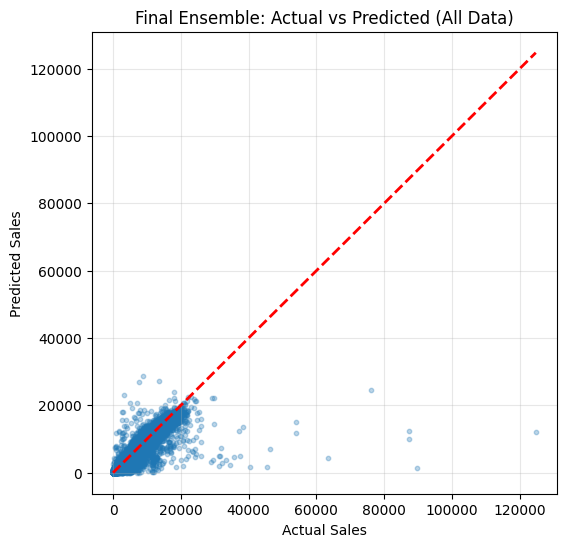

In [68]:
# Actual vs Predicted ScatterPlot
plt.figure(figsize=(6, 6))

plt.scatter(
    y_true_real,
    y_pred_final,
    alpha=0.3,
    s=10
)

max_val = max(y_true_real.max(), y_pred_final.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Final Ensemble: Actual vs Predicted (All Data)")
plt.grid(alpha=0.3)
plt.show()


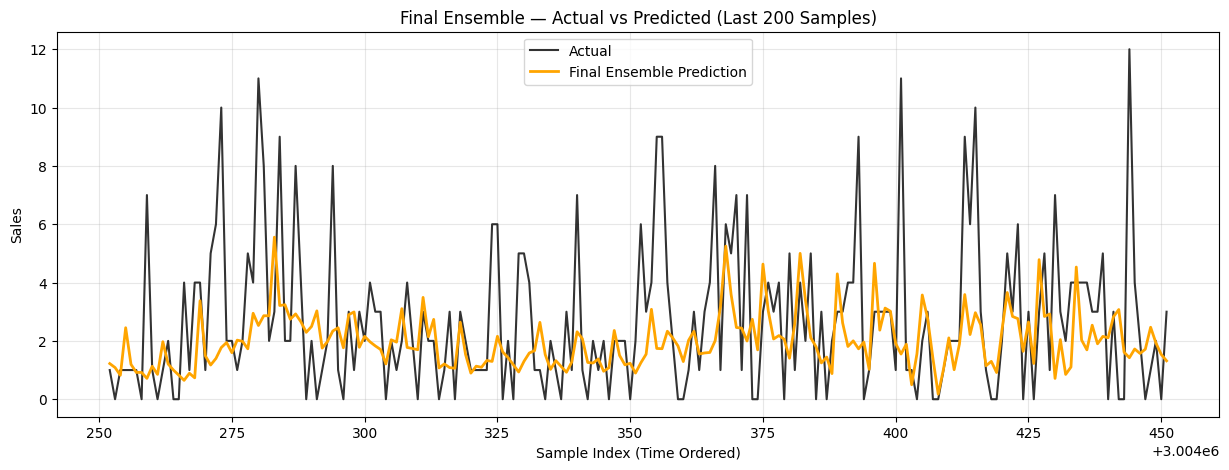

In [69]:
# Plot last 200 Samples
WINDOW = 200

idx = np.arange(len(y_true_real))[-WINDOW:]

plt.figure(figsize=(15, 5))

plt.plot(
    idx,
    y_true_real[-WINDOW:],
    label="Actual",
    color="black",
    linewidth=1.5,
    alpha=0.8
)

plt.plot(
    idx,
    y_pred_final[-WINDOW:],
    label="Final Ensemble Prediction",
    color="orange",
    linewidth=2
)

plt.title("Final Ensemble — Actual vs Predicted (Last 200 Samples)")
plt.xlabel("Sample Index (Time Ordered)")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


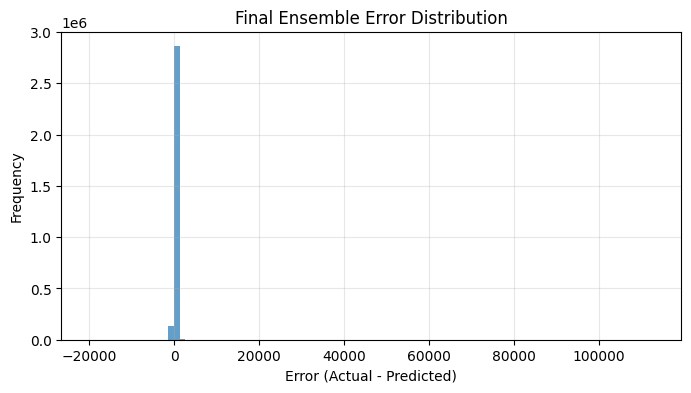

In [70]:
# Error Distribution
errors = y_true_real - y_pred_final

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=100, alpha=0.7)
plt.title("Final Ensemble Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


# Predictions on Test Set

In [71]:
# Load Test Data
test = pd.read_parquet(DATA_DIR / "test_features.parquet")

test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

print(test.shape)

(28512, 38)


In [ ]:
# Seed Lags Using TRAIN DATA
# Take last 28 days from train as history
HISTORY_DAYS = 28

history = (
    train
    .sort_values(['store_nbr', 'family', 'date'])
    .groupby(['store_nbr', 'family'])
    .tail(HISTORY_DAYS)
    .copy()
)

history = history[['store_nbr', 'family', 'date', 'sales_log']]
